In [5]:
# 確定版 動画統合コード Worm2, 3, 4：スケールバー長の小数をα合成で正確に反映
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm

# === 動画ファイルパス ===
video_paths = {
    "Worm2": "Worm2_orthogonal_view_20240508-174849tdTomato-12mW-3_raw_gzip_bleachcorrect__top90_mean_full_adjustedG389M1245_minpad.mp4",
    "Worm3": "Worm3_orthogonal_view_20240508-200229tdTomato-10mW-4_raw_gzip_bleachcorrect_top90_mean_full_adjustedG495M2544_minpad.mp4",
    "Worm4": "Worm4_orthogonal_view_20240516-203245tdTomato-7mW-3_raw_gzip_bleachcorrect_top90_mean_full_adjustedG437M1643_minpad.mp4"
}

# === VideoCapture 初期化 ===
caps = {name: cv2.VideoCapture(path) for name, path in video_paths.items()}

# === 動画情報取得（Worm2 を基準）===
fps = float(caps["Worm2"].get(cv2.CAP_PROP_FPS))
n_frames = int(min(caps["Worm2"].get(cv2.CAP_PROP_FRAME_COUNT),
                   caps["Worm3"].get(cv2.CAP_PROP_FRAME_COUNT),
                   caps["Worm4"].get(cv2.CAP_PROP_FRAME_COUNT)))
base_h = int(caps["Worm2"].get(cv2.CAP_PROP_FRAME_HEIGHT))
base_w = int(caps["Worm2"].get(cv2.CAP_PROP_FRAME_WIDTH))

# === フォント設定（macOS）===
regular_font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
italic_font_path  = "/System/Library/Fonts/Supplemental/Arial Italic.ttf"
label_font    = ImageFont.truetype(regular_font_path, 24)
timer_font    = ImageFont.truetype(regular_font_path, 22)
sub_label_font= ImageFont.truetype(italic_font_path, 20)

# === マージン設定 ===
inter_col_margin = 30
inter_row_margin = 40
side_margin = 20
bottom_margin = 20
top_margin = bottom_margin  # タイマー位置を下げたので上下を揃える

canvas_w = base_w * 2 + inter_col_margin + side_margin * 2
canvas_h = base_h * 2 + inter_row_margin + top_margin + bottom_margin

# === 出力VideoWriter初期化 ===
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("combined_output_c.mp4", fourcc, fps, (canvas_w, canvas_h))

# ---- α合成ユーティリティ（BGR画像に1ピクセル幅の帯をブレンド）----
def _alpha_blend_strip(img_bgr, x, y, w, h, color_bgr, alpha):
    if w <= 0 or h <= 0 or alpha <= 0:
        return
    H, W = img_bgr.shape[:2]
    x0, y0 = max(0, x), max(0, y)
    x1, y1 = min(W, x + w), min(H, y + h)
    if x1 <= x0 or y1 <= y0:
        return
    roi = img_bgr[y0:y1, x0:x1].astype(np.float32)
    overlay = np.empty_like(roi, dtype=np.float32)
    overlay[..., 0] = color_bgr[0]
    overlay[..., 1] = color_bgr[1]
    overlay[..., 2] = color_bgr[2]
    blended = (1.0 - alpha) * roi + alpha * overlay
    img_bgr[y0:y1, x0:x1] = blended.astype(np.uint8)

def draw_scale_bar_subpixel(img_bgr, start_xy, length_px, thickness_px, color_bgr=(255,255,255)):
    """
    左端(start_xy)から右向きに length_px（小数可）のスケールバーを描画。
    整数部は通常塗り、小数部は終端1列を α=小数部 でブレンド。
    """
    x0, y0 = int(round(start_xy[0])), int(round(start_xy[1]))
    H, W = img_bgr.shape[:2]
    if thickness_px <= 0 or length_px <= 0:
        return

    x_end_f = x0 + float(length_px)
    x_end_floor = int(np.floor(x_end_f))
    frac = x_end_f - x_end_floor  # 0<=frac<1

    # 整数部を通常描画
    full_w = x_end_floor - x0
    if full_w > 0:
        x_full0 = max(0, x0)
        x_full1 = min(W - 1, x0 + full_w - 1)
        y0_c = max(0, y0)
        y1_c = min(H - 1, y0 + thickness_px - 1)
        if x_full1 >= x_full0 and y1_c >= y0_c:
            cv2.rectangle(img_bgr, (x_full0, y0_c), (x_full1, y1_c), color_bgr, thickness=-1)

    # 小数部を終端1列に α 合成
    if frac > 0.0:
        x_alpha = x_end_floor
        if 0 <= x_alpha < W:
            _alpha_blend_strip(img_bgr, x_alpha, y0, 1, thickness_px, color_bgr, float(frac))

# === フレームループ ===
for frame_index in tqdm(range(n_frames), desc="動画生成中"):
    frames = {}
    for name in video_paths:
        ret, frame = caps[name].read()
        if not ret:
            raise RuntimeError(f"{name} のフレーム読み込みに失敗しました")
        if name != "Worm2":
            frame = cv2.resize(frame, (base_w, base_h), interpolation=cv2.INTER_AREA)
        frames[name] = frame

    # キャンバスへ配置
    canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)
    x0 = side_margin
    x1 = x0 + base_w + inter_col_margin
    y0 = top_margin
    y1 = y0 + base_h
    y2 = y1 + inter_row_margin

    canvas[y0:y1, x0:x0 + base_w] = frames["Worm2"]
    canvas[y0:y1, x1:x1 + base_w] = frames["Worm3"]
    canvas[y2:y2 + base_h, x0:x0 + base_w] = frames["Worm4"]

    # === Pillowでラベル類を描画 ===
    canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(canvas_rgb)
    draw = ImageDraw.Draw(img_pil)

    # Wormラベル
    draw.text((x0 + 8, y0 + 5), "Worm 2", font=label_font, fill=(255, 255, 255))
    draw.text((x1 + 8, y0 + 5), "Worm 3", font=label_font, fill=(255, 255, 255))
    draw.text((x0 + 8, y2 + 5), "Worm 4", font=label_font, fill=(255, 255, 255))

    # タイマー（Worm2ラベル直下）
    time_sec = frame_index / fps
    draw.text((x0 + 8, y0 + 35), f"T={time_sec:.2f} s", font=timer_font, fill=(255, 255, 255))

    # xy/xz/yz ラベル（Worm2のみ）
    draw.text((30, 290), "xy", font=sub_label_font, fill=(255, 255, 255))
    draw.text((30, 330), "xz", font=sub_label_font, fill=(255, 255, 255))
    draw.text((590, 290), "yz", font=sub_label_font, fill=(255, 255, 255))

    # === スケールバー（小数長をα合成で反映：Worm2 xy 右下）===
    # 元コードと同じ位置指定を踏襲しつつ、小数を厳密に描く
    scale_bar_px = 48.84      # ← 小数を含む長さ
    bar_height   = 2
    bar_x_end = x0 + base_w - 120
    bar_y     = y0 + base_h - 120
    bar_x_start = bar_x_end - scale_bar_px

    # いったん PIL → BGR に戻してバーを描画
    canvas_bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    draw_scale_bar_subpixel(
        canvas_bgr,
        (bar_x_start, bar_y),  # 左端（小数含むが内部で丸め＆α処理）
        scale_bar_px,
        bar_height,
        color_bgr=(255, 255, 255)
    )

    # === 書き出し ===
    out.write(canvas_bgr)

# === 終了処理 ===
for cap in caps.values():
    cap.release()
out.release()
print("✅ 完了: combined_output_c.mp4 が生成されました")


動画生成中: 100%|███████████████████████████| 9995/9995 [06:55<00:00, 24.06it/s]


✅ 完了: combined_output_c.mp4 が生成されました


In [3]:
# 確定版 + 1枚目プレビュー保存
# 動画統合コード Worm2, 3, 4：スケールバー長の小数をα合成で正確に反映（プレビューPNG対応）

import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm

# === 設定 ===
PREVIEW_ONLY = False
preview_path = "combined_output_c_firstframe.png"
output_path  = "combined_output_c.mp4"

# === 動画ファイルパス ===
video_paths = {
    "Worm2": "Worm2_orthogonal_view_20240508-174849tdTomato-12mW-3_raw_gzip_bleachcorrect__top90_mean_full_adjustedG389M1245_minpad.mp4",
    "Worm3": "Worm3_orthogonal_view_20240508-200229tdTomato-10mW-4_raw_gzip_bleachcorrect_top90_mean_full_adjustedG495M2544_minpad.mp4",
    "Worm4": "Worm4_orthogonal_view_20240516-203245tdTomato-7mW-3_raw_gzip_bleachcorrect_top90_mean_full_adjustedG437M1643_minpad.mp4"
}

# === VideoCapture 初期化 ===
caps = {name: cv2.VideoCapture(path) for name, path in video_paths.items()}
for name, cap in caps.items():
    if not cap.isOpened():
        raise RuntimeError(f"❌ 開けません: {video_paths[name]}")

# === 動画情報取得（Worm2 を基準）===
fps = float(caps["Worm2"].get(cv2.CAP_PROP_FPS))
n_frames = int(min(caps["Worm2"].get(cv2.CAP_PROP_FRAME_COUNT),
                   caps["Worm3"].get(cv2.CAP_PROP_FRAME_COUNT),
                   caps["Worm4"].get(cv2.CAP_PROP_FRAME_COUNT)))
base_h = int(caps["Worm2"].get(cv2.CAP_PROP_FRAME_HEIGHT))
base_w = int(caps["Worm2"].get(cv2.CAP_PROP_FRAME_WIDTH))

# === フォント設定（macOS）===
regular_font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
italic_font_path  = "/System/Library/Fonts/Supplemental/Arial Italic.ttf"
label_font     = ImageFont.truetype(regular_font_path, 24)
timer_font     = ImageFont.truetype(regular_font_path, 22)
sub_label_font = ImageFont.truetype(italic_font_path, 20)

# === マージン設定 ===
inter_col_margin = 30
inter_row_margin = 40
side_margin = 20
bottom_margin = 20
top_margin = bottom_margin  # タイマー位置調整に合わせて上下を揃える

canvas_w = base_w * 2 + inter_col_margin + side_margin * 2
canvas_h = base_h * 2 + inter_row_margin + top_margin + bottom_margin

# === 出力VideoWriter初期化 ===
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = None
if not PREVIEW_ONLY:
    out = cv2.VideoWriter(output_path, fourcc, fps, (canvas_w, canvas_h))
    if not out.isOpened():
        raise RuntimeError("❌ 出力VideoWriterを開けません")

# ---- α合成ユーティリティ（BGR画像に1ピクセル幅の帯をブレンド）----
def _alpha_blend_strip(img_bgr, x, y, w, h, color_bgr, alpha):
    if w <= 0 or h <= 0 or alpha <= 0:
        return
    H, W = img_bgr.shape[:2]
    x0, y0 = max(0, x), max(0, y)
    x1, y1 = min(W, x + w), min(H, y + h)
    if x1 <= x0 or y1 <= y0:
        return
    roi = img_bgr[y0:y1, x0:x1].astype(np.float32)
    overlay = np.empty_like(roi, dtype=np.float32)
    overlay[..., 0] = color_bgr[0]
    overlay[..., 1] = color_bgr[1]
    overlay[..., 2] = color_bgr[2]
    blended = (1.0 - alpha) * roi + alpha * overlay
    img_bgr[y0:y1, x0:x1] = blended.astype(np.uint8)

def draw_scale_bar_subpixel(img_bgr, start_xy, length_px, thickness_px, color_bgr=(255,255,255)):
    """
    左端(start_xy)から右向きに length_px（小数可）のスケールバーを描画。
    整数部は通常塗り、小数部は終端1列を α=小数部 でブレンド。
    """
    x0, y0 = int(round(start_xy[0])), int(round(start_xy[1]))
    H, W = img_bgr.shape[:2]
    if thickness_px <= 0 or length_px <= 0:
        return

    x_end_f = x0 + float(length_px)
    x_end_floor = int(np.floor(x_end_f))
    frac = x_end_f - x_end_floor  # 0<=frac<1

    # 整数部を通常描画
    full_w = x_end_floor - x0
    if full_w > 0:
        x_full0 = max(0, x0)
        x_full1 = min(W - 1, x0 + full_w - 1)
        y0_c = max(0, y0)
        y1_c = min(H - 1, y0 + thickness_px - 1)
        if x_full1 >= x_full0 and y1_c >= y0_c:
            cv2.rectangle(img_bgr, (x_full0, y0_c), (x_full1, y1_c), color_bgr, thickness=-1)

    # 小数部を終端1列に α 合成
    if frac > 0.0:
        x_alpha = x_end_floor
        if 0 <= x_alpha < W:
            _alpha_blend_strip(img_bgr, x_alpha, y0, 1, thickness_px, color_bgr, float(frac))

def compose_frame(frames_dict, frame_idx):
    """3枚のフレームをキャンバスに配置し、ラベルとスケールバーを描画して返す（BGR）"""
    # キャンバスへ配置
    canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)
    x0 = side_margin
    x1 = x0 + base_w + inter_col_margin
    y0 = top_margin
    y1 = y0 + base_h
    y2 = y1 + inter_row_margin

    canvas[y0:y1, x0:x0 + base_w] = frames_dict["Worm2"]
    canvas[y0:y1, x1:x1 + base_w] = frames_dict["Worm3"]
    canvas[y2:y2 + base_h, x0:x0 + base_w] = frames_dict["Worm4"]

    # Pillowでラベル類
    canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(canvas_rgb)
    draw = ImageDraw.Draw(img_pil)

    # Wormラベル
    draw.text((x0 + 8, y0 + 5), "Worm 2", font=label_font, fill=(255, 255, 255))
    draw.text((x1 + 8, y0 + 5), "Worm 3", font=label_font, fill=(255, 255, 255))
    draw.text((x0 + 8, y2 + 5), "Worm 4", font=label_font, fill=(255, 255, 255))

    # タイマー（Worm2ラベル直下）
    time_sec = frame_idx / fps
    draw.text((x0 + 8, y0 + 35), f"T={time_sec:.2f} s", font=timer_font, fill=(255, 255, 255))

    # xy/xz/yz ラベル（Worm2のみ）
    draw.text((30, 290), "xy", font=sub_label_font, fill=(255, 255, 255))
    draw.text((30, 330), "xz", font=sub_label_font, fill=(255, 255, 255))
    draw.text((590, 290), "yz", font=sub_label_font, fill=(255, 255, 255))

    # BGRに戻す（スケールバーはBGRで小数α対応）
    canvas_bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

    # スケールバー（小数長をα合成で反映：Worm2 xy 右下）
    scale_bar_px = 48.84
    bar_height   = 2
    bar_x_end = x0 + base_w - 120
    bar_y     = y0 + base_h - 120
    bar_x_start = bar_x_end - scale_bar_px
    draw_scale_bar_subpixel(canvas_bgr, (bar_x_start, bar_y), scale_bar_px, bar_height, (255,255,255))

    return canvas_bgr

# === 1枚目を読み込んでプレビュー保存 ===
frames0 = {}
for name in video_paths:
    ret, f0 = caps[name].read()
    if not ret:
        raise RuntimeError(f"{name} の1枚目読み込みに失敗しました")
    if name != "Worm2":
        f0 = cv2.resize(f0, (base_w, base_h), interpolation=cv2.INTER_AREA)
    frames0[name] = f0

first_bgr = compose_frame(frames0, frame_idx=0)
ok = cv2.imwrite(preview_path, first_bgr)
print("🖼 1枚目を保存:", preview_path if ok else "⚠️ 失敗")

if PREVIEW_ONLY:
    for cap in caps.values():
        cap.release()
    print("✅ プレビューのみ完了（動画は出力しません）")
else:
    # 動画にも1枚目を書き込み
    out.write(first_bgr)

    # === 2枚目以降 ===
    for i in tqdm(range(1, n_frames), desc="動画生成中"):
        frames_i = {}
        for name in video_paths:
            ret, fi = caps[name].read()
            if not ret:
                # 最短の動画に合わせているので通常は来ないが、保険で break
                break
            if name != "Worm2":
                fi = cv2.resize(fi, (base_w, base_h), interpolation=cv2.INTER_AREA)
            frames_i[name] = fi
        if len(frames_i) != 3:
            break
        out.write(compose_frame(frames_i, frame_idx=i))

    # 後処理
    for cap in caps.values():
        cap.release()
    out.release()
    print("✅ 完了:", output_path)


🖼 1枚目を保存: combined_output_c_firstframe.png


動画生成中:   4%|█▏                          | 406/9994 [00:20<08:00, 19.96it/s]


KeyboardInterrupt: 

In [11]:
# 動画統合コード Worm2, 3, 4を適切な位置に配置する（タイマーとマージン修正済み、xy/xz/yz位置も補正）

import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm

# === 動画ファイルパス ===
video_paths = {
    "Worm2": "Worm2_orthogonal_view_20240508-174849tdTomato-12mW-3_raw_gzip_bleachcorrect__top90_mean_full_adjustedG389M1245_minpad.mp4",
    "Worm3_orthogonal_view_20240508-200229tdTomato-10mW-4_raw_gzip_bleachcorrect_top90_mean_full_adjustedG495M2544_minpad.mp4",
    "Worm4": "Worm3_orthogonal_view_20240508-200229tdTomato-10mW-4_raw_gzip_bleachcorrect_top90_mean_full_adjustedG495M2544.mp4"
}

# === VideoCapture 初期化 ===
caps = {name: cv2.VideoCapture(path) for name, path in video_paths.items()}

# === 動画情報取得（Worm2 を基準）===
fps = int(caps["Worm2"].get(cv2.CAP_PROP_FPS))
n_frames = int(min(caps["Worm2"].get(cv2.CAP_PROP_FRAME_COUNT),
                   caps["Worm3"].get(cv2.CAP_PROP_FRAME_COUNT),
                   caps["Worm4"].get(cv2.CAP_PROP_FRAME_COUNT)))
base_h = int(caps["Worm2"].get(cv2.CAP_PROP_FRAME_HEIGHT))
base_w = int(caps["Worm2"].get(cv2.CAP_PROP_FRAME_WIDTH))

# === フォント設定（macOS）===
regular_font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"
italic_font_path = "/System/Library/Fonts/Supplemental/Arial Italic.ttf"
label_font = ImageFont.truetype(regular_font_path, 24)
timer_font = ImageFont.truetype(regular_font_path, 22)
sub_label_font = ImageFont.truetype(italic_font_path, 20)

# === マージン設定 ===
inter_col_margin = 30
inter_row_margin = 40
side_margin = 20
bottom_margin = 20
top_margin = bottom_margin  # タイマーを移動したので上余白を下と揃える

canvas_w = base_w * 2 + inter_col_margin + side_margin * 2
canvas_h = base_h * 2 + inter_row_margin + top_margin + bottom_margin

# === 出力VideoWriter初期化 ===
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("combined_output_c.mp4", fourcc, fps, (canvas_w, canvas_h))

# === フレームループ ===
for frame_index in tqdm(range(n_frames), desc="動画生成中"):
    frames = {}
    for name in video_paths:
        ret, frame = caps[name].read()
        if not ret:
            raise RuntimeError(f"{name} のフレーム読み込みに失敗しました")
        if name != "Worm2":
            frame = cv2.resize(frame, (base_w, base_h), interpolation=cv2.INTER_AREA)
        frames[name] = frame

    # キャンバス作成
    canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)
    x0 = side_margin
    x1 = x0 + base_w + inter_col_margin
    y0 = top_margin
    y1 = y0 + base_h
    y2 = y1 + inter_row_margin

    canvas[y0:y1, x0:x0 + base_w] = frames["Worm2"]
    canvas[y0:y1, x1:x1 + base_w] = frames["Worm3"]
    canvas[y2:y2 + base_h, x0:x0 + base_w] = frames["Worm4"]

    # === Pillowで注釈追加 ===
    canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(canvas_rgb)
    draw = ImageDraw.Draw(img_pil)

    # Wormラベル
    draw.text((x0 + 8, y0 + 5), "Worm 2", font=label_font, fill=(255, 255, 255))
    draw.text((x1 + 8, y0 + 5), "Worm 3", font=label_font, fill=(255, 255, 255))
    draw.text((x0 + 8, y2 + 5), "Worm 4", font=label_font, fill=(255, 255, 255))

    # タイマーをWorm2ラベルの直下に移動
    time_sec = frame_index / fps
    draw.text((x0 + 8, y0 + 35), f"T={time_sec:.2f} s", font=timer_font, fill=(255, 255, 255))

    # xy/xz/yz ラベル（Worm2のみ、マージン修正に応じてY位置補正）
    draw.text((30, 290), "xy", font=sub_label_font, fill=(255, 255, 255))
    draw.text((30, 330), "xz", font=sub_label_font, fill=(255, 255, 255))
    draw.text((590, 290), "yz", font=sub_label_font, fill=(255, 255, 255))

    # === スケールバー追加（Worm2 xy右下）===
    scale_bar_length_um = 20  # μm
    pixel_size_um = 0.4095
    scale_bar_px = 48.84
    bar_height = 2
    bar_x_end = x0 + base_w - 120
    bar_x_start = bar_x_end - scale_bar_px
    bar_y = y0 + base_h - 120
    draw.rectangle([bar_x_start, bar_y, bar_x_end, bar_y + bar_height], fill=(255, 255, 255))

    # === 書き出し ===
    final = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    out.write(final)

# === 終了処理 ===
for cap in caps.values():
    cap.release()
out.release()
print("✅ 完了: combined_output.mp4 が生成されました")


動画生成中: 100%|███████████████████████████| 9995/9995 [03:35<00:00, 46.37it/s]

✅ 完了: combined_output.mp4 が生成されました


In [3]:
#動画統合コード Worm2, 3, 4を適切な位置に配置する

import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm

# === 動画ファイルパス ===
video_paths = {
    "Worm2": "Worm2c2.mp4",
    "Worm3": "Worm3c.mp4",
    "Worm4": "Worm4c.mp4"
}

# === VideoCapture 初期化 ===
caps = {name: cv2.VideoCapture(path) for name, path in video_paths.items()}

# === 動画情報取得（Worm2 を基準）===
fps = int(caps["Worm2"].get(cv2.CAP_PROP_FPS))
n_frames = int(min(caps["Worm2"].get(cv2.CAP_PROP_FRAME_COUNT),
                   caps["Worm3"].get(cv2.CAP_PROP_FRAME_COUNT),
                   caps["Worm4"].get(cv2.CAP_PROP_FRAME_COUNT)))
base_h = int(caps["Worm2"].get(cv2.CAP_PROP_FRAME_HEIGHT))
base_w = int(caps["Worm2"].get(cv2.CAP_PROP_FRAME_WIDTH))

# === フォント設定（macOS）===
# 非イタリック（標準書体）フォント：Wormラベル & タイマー
regular_font_path = "/System/Library/Fonts/Supplemental/Arial.ttf"

# イタリックフォント：xy, xz, yz
italic_font_path = "/System/Library/Fonts/Supplemental/Arial Italic.ttf"

# フォント割り当て
label_font = ImageFont.truetype(regular_font_path, 24)      # Worm 2, 3, 4
timer_font = ImageFont.truetype(regular_font_path, 22)      # T = xx.xx s
sub_label_font = ImageFont.truetype(italic_font_path, 20)   # xy, xz, yz


# === マージン設定 ===
inter_col_margin = 30
inter_row_margin = 40
side_margin = 20
top_margin = 40
bottom_margin = 20

canvas_w = base_w * 2 + inter_col_margin + side_margin * 2
canvas_h = base_h * 2 + inter_row_margin + top_margin + bottom_margin

# === 出力VideoWriter初期化 ===
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter("combined_output_c.mp4", fourcc, fps, (canvas_w, canvas_h))

# === フレームループ ===
for frame_index in tqdm(range(n_frames), desc="動画生成中"):
    frames = {}
    for name in video_paths:
        ret, frame = caps[name].read()
        if not ret:
            raise RuntimeError(f"{name} のフレーム読み込みに失敗しました")
        if name != "Worm2":
            frame = cv2.resize(frame, (base_w, base_h), interpolation=cv2.INTER_AREA)
        frames[name] = frame

    # キャンバス作成
    canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)
    x0 = side_margin
    x1 = x0 + base_w + inter_col_margin
    y0 = top_margin
    y1 = y0 + base_h
    y2 = y1 + inter_row_margin

    canvas[y0:y1, x0:x0 + base_w] = frames["Worm2"]
    canvas[y0:y1, x1:x1 + base_w] = frames["Worm3"]
    canvas[y2:y2 + base_h, x0:x0 + base_w] = frames["Worm4"]

    # === Pillowで注釈追加 ===
    canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(canvas_rgb)
    draw = ImageDraw.Draw(img_pil)

    # タイマー
    time_sec = frame_index / fps
    draw.text((x0, y0 - 30), f"T={time_sec:.2f} s", font=timer_font, fill=(255, 255, 255))

    # 黒マスク（元タイマー隠し）
   # mask_box = (2, 2, 132, 32)
    #for dx, dy in [(x0, y0), (x1, y0), (x0, y2)]:
      #  draw.rectangle((dx + mask_box[0], dy + mask_box[1], dx + mask_box[2], dy + mask_box[3]),
        #               fill=(0, 0, 0))

    # Wormラベル
    draw.text((x0 + 8, y0 + 5), "Worm 2", font=label_font, fill=(255, 255, 255))
    draw.text((x1 + 8, y0 + 5), "Worm 3", font=label_font, fill=(255, 255, 255))
    draw.text((x0 + 8, y2 + 5), "Worm 4", font=label_font, fill=(255, 255, 255))

    # xy/xz/yz ラベル（Worm2のみ）
    draw.text((30, 310), "xy", font=sub_label_font, fill=(255, 255, 255))
    draw.text((30, 350), "xz", font=sub_label_font, fill=(255, 255, 255))
    draw.text((590, 310), "yz", font=sub_label_font, fill=(255, 255, 255))

    # === 書き出し ===
    final = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    out.write(final)

# === 終了処理 ===
for cap in caps.values():
    cap.release()
out.release()
print("✅ 完了: combined_output.mp4 が生成されました")


動画生成中: 100%|███████████████████████████| 9995/9995 [05:39<00:00, 29.45it/s]

✅ 完了: combined_output.mp4 が生成されました


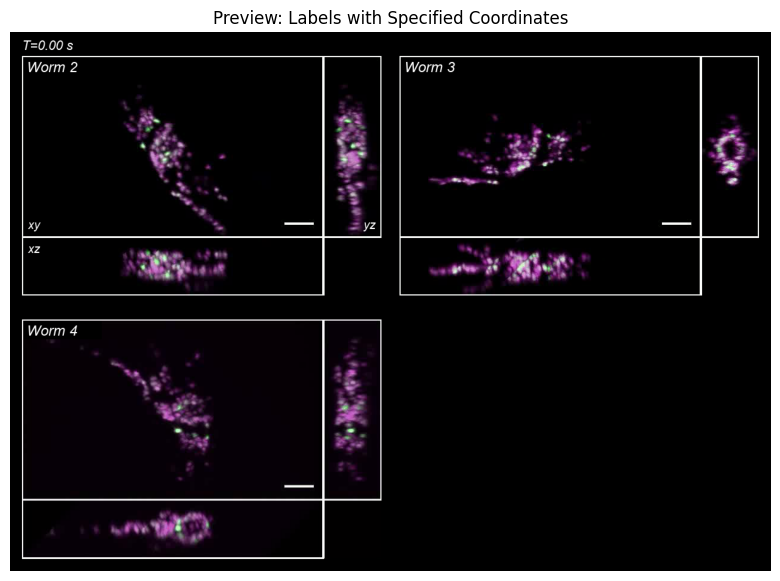

In [7]:
#画像確認用
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# === 動画ファイルパス ===
video_paths = {
    "Worm2": "Worm_2_.mp4",
    "Worm3": "Worm_3_.mp4",
    "Worm4": "Worm_4_.mp4"
}

# === VideoCapture 初期化・1フレーム読み込み ===
caps = {name: cv2.VideoCapture(path) for name, path in video_paths.items()}
frames = {}
for name, cap in caps.items():
    ret, frame = cap.read()
    if not ret:
        raise RuntimeError(f"{name} の動画が読み込めません")
    frames[name] = frame
    cap.release()

# === Worm2 を基準にサイズ取得・他もリサイズ ===
base_h, base_w = frames["Worm2"].shape[:2]
for name in ["Worm3", "Worm4"]:
    frames[name] = cv2.resize(frames[name], (base_w, base_h), interpolation=cv2.INTER_AREA)

# === フォント設定（macOS用）===
font_path = "/System/Library/Fonts/Supplemental/Arial Italic.ttf"
label_font = ImageFont.truetype(font_path, 24)
sub_label_font = ImageFont.truetype(font_path, 20)
timer_font = ImageFont.truetype(font_path, 22)

# === レイアウトマージン設定 ===
inter_col_margin = 30  # Worm2 と Worm3 の間
inter_row_margin = 40  # Worm2/3 と Worm4 の間
side_margin = 20       # 左右マージン
top_margin = 40        # 上マージン（タイマー用）
bottom_margin = 20

canvas_w = base_w * 2 + inter_col_margin + side_margin * 2
canvas_h = base_h * 2 + inter_row_margin + top_margin + bottom_margin

# === キャンバス作成 & フレーム配置 ===
canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)

# 配置座標計算
x0 = side_margin
x1 = x0 + base_w + inter_col_margin
y0 = top_margin
y1 = y0 + base_h
y2 = y1 + inter_row_margin

canvas[y0:y1, x0:x0 + base_w] = frames["Worm2"]
canvas[y0:y1, x1:x1 + base_w] = frames["Worm3"]
canvas[y2:y2 + base_h, x0:x0 + base_w] = frames["Worm4"]

# === Pillowで注釈追加 ===
canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
img_pil = Image.fromarray(canvas_rgb)
draw = ImageDraw.Draw(img_pil)

# === タイマー描画（Worm2の外・左上）===
draw.text((x0, y0 - 30), "T=0.00 s", font=timer_font, fill=(255, 255, 255))

# === 黒マスク描画（各xy左上に）===
mask_box = (2, 2, 2 + 130, 2 + 30)
for dx, dy in [(x0, y0), (x1, y0), (x0, y2)]:
    mask_coords = (dx + mask_box[0], dy + mask_box[1], dx + mask_box[2], dy + mask_box[3])
    draw.rectangle(mask_coords, fill=(0, 0, 0))

# === Worm ラベル描画（各マスク内）===
draw.text((x0 + 8, y0 + 5), "Worm 2", font=label_font, fill=(255, 255, 255))
draw.text((x1 + 8, y0 + 5), "Worm 3", font=label_font, fill=(255, 255, 255))
draw.text((x0 + 8, y2 + 5), "Worm 4", font=label_font, fill=(255, 255, 255))

# === xy/xz/yz ラベル（Worm2）: 指定座標で配置 ===
draw.text((30, 310), "xy", font=sub_label_font, fill=(255, 255, 255))
draw.text((30, 350), "xz", font=sub_label_font, fill=(255, 255, 255))
draw.text((590, 310), "yz", font=sub_label_font, fill=(255, 255, 255))

# === 保存 & 表示 ===
final = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
cv2.imwrite("combined_preview_final.png", final)

plt.figure(figsize=(10, 7))
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))
plt.title("Preview: Labels with Specified Coordinates")
plt.axis("off")
plt.show()
